# Explore Risk Factors for COVID-19 for Counties in US States
[Work in progress]

This notebook explores the relationsship between risk factors selected from the American Community Survey 2018 5-year estimates on COVID-19 confirmed case and death rate.

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

#### Setup dropdown menus

In [4]:
query = """
// get list of states in the US
MATCH (a:Admin1)-[:IN]->(Country{name: 'United States'})
RETURN a.name as state
ORDER BY state
"""
states = graph.run(query).to_data_frame()['state'].values

In [5]:
state_widget = widgets.Dropdown(options=states, description='Select state:', value='California')
metric_widget = widgets.Dropdown(options=('confirmedRate', 'deathRate'), description='Select metric')

### Query KG to get Confirmed Cases, Deaths, and Population for Counties in a State

In [6]:
display(state_widget)

Dropdown(description='Select state:', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Californi…

In [7]:
display(metric_widget)

Dropdown(description='Select metric', options=('confirmedRate', 'deathRate'), value='confirmedRate')

In [8]:
state = state_widget.value
metric = metric_widget.value
print('State :', state)
print('Metric:', metric)

State : California
Metric: confirmedRate


In [9]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths for all counties in a state

In [10]:
query = """
// get all counties (admin2) in a state (admin1)
MATCH (a:Admin2)-[:IN]->(:Admin1{name: $admin1})

// get COVID-19 cases for all counties
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'}) 
WHERE c.date >= date($start_date)

// get demographics for all counties
MATCH (a)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

RETURN a.name AS name, c.date AS date, 
       c.cummulativeConfirmed*100000.0/d.totalPopulation AS confirmedRate, 
       c.cummulativeDeaths*100000.0/d.totalPopulation AS deathRate
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, admin1=state, start_date=start_date).to_data_frame()

Reformat data

In [11]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,Alameda County,Alpine County,Amador County,Butte County,Calaveras County,City and County of San Francisco,Colusa County,Contra Costa County,Del Norte County,El Dorado County,Fresno County,Glenn County,Humboldt County,Imperial County,Inyo County,Kern County,Kings County,Lake County,Lassen County,Los Angeles County,Madera County,Marin County,Mariposa County,Mendocino County,Merced County,Modoc County,Mono County,Monterey County,Napa County,Nevada County,Orange County,Placer County,Plumas County,Riverside County,Sacramento County,San Benito County,San Bernardino County,San Diego County,San Joaquin County,San Luis Obispo County,San Mateo County,Santa Barbara County,Santa Clara County,Santa Cruz County,Shasta County,Sierra County,Siskiyou County,Solano County,Sonoma County,Stanislaus County,Sutter County,Tehama County,Trinity County,Tulare County,Tuolumne County,Ventura County,Yolo County,Yuba County
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,19.042404,87.260035,5.286949,3.523065,6.632033,49.882535,4.658964,21.972262,0.000000,9.643150,6.952041,7.16923,19.886866,21.085808,49.764999,12.456783,2.665334,0.0,0.0,34.838402,14.837465,41.107205,0.0,4.575507,3.716436,0.0,91.717229,9.695022,10.673877,26.238243,19.151869,20.522157,5.347880,15.566743,14.834211,35.344015,8.569771,22.193069,20.622443,28.423727,50.657040,22.310462,49.734679,17.898563,3.908758,0.0,6.890216,11.173694,15.559018,7.231583,10.430574,0.000000,0.0,9.772475,3.708374,18.865433,11.629151,9.272383
2020-04-02,21.840969,87.260035,7.930424,3.963448,6.632033,51.721522,4.658964,22.060504,0.000000,9.643150,8.383344,7.16923,20.623416,23.860257,49.764999,16.080575,3.331667,0.0,0.0,40.057231,16.127680,41.491385,0.0,4.575507,4.459723,0.0,126.993086,11.080025,12.808653,26.238243,20.732056,23.679412,5.347880,20.685726,20.794385,38.710112,11.894655,25.705205,23.627037,31.621396,59.143400,25.014761,53.012174,19.724947,3.908758,0.0,6.890216,12.313867,18.152187,8.158709,14.602804,0.000000,0.0,16.070292,3.708374,20.869885,13.024649,10.597009
2020-04-03,26.951390,87.260035,7.930424,4.403831,6.632033,57.123548,4.658964,27.090299,3.646441,10.178880,9.610175,7.16923,27.252372,28.854264,55.294443,19.591123,3.331667,0.0,0.0,45.216642,18.063001,45.333180,0.0,4.575507,5.946298,0.0,126.993086,12.234195,12.808653,30.274896,22.470262,25.521144,5.347880,20.685726,25.827421,38.710112,14.236122,29.247619,24.583044,33.042582,63.451859,31.324791,53.012174,20.820777,6.142335,0.0,6.890216,13.910109,18.950085,9.456686,14.602804,0.000000,0.0,17.590455,3.708374,22.284793,15.350479,10.597009
2020-04-04,26.951390,87.260035,7.930424,4.844214,8.842710,60.801523,9.317928,27.090299,7.292882,11.786072,10.223590,7.16923,32.408226,30.518933,55.294443,23.781132,3.331667,0.0,0.0,45.602855,18.063001,50.327513,0.0,4.575507,5.946298,0.0,134.048257,13.157530,14.231837,31.284059,24.840543,25.521144,10.695759,26.769762,25.827421,38.710112,16.530760,33.668066,25.265907,33.042582,70.240947,34.254447,59.723234,21.551331,6.700729,0.0,6.890216,16.646524,20.944831,10.754662,16.688919,1.577959,0.0,17.590455,3.708374,23.935518,17.211144,11.921635
2020-04-05,34.434508,87.260035,0.000000,4.844214,8.842710,65.284055,9.317928,34.061418,7.292882,11.786072,10.530298,7.16923,32.408226,31.628712,60.823887,26.046002,3.331667,0.0,0.0,58.971770,18.063001,52.632590,0.0,4.575507,10.034377,0.0,134.048257,14.311700,14.231837,31.284059,26.357523,27.099772,16.043639,33.525141,29.271077,38.710112,17.420518,36.604939,26.085341,33.753175,72.460457,37.860179,62.792633,25.204098,9.492699,0.0,6.890216,16.646524,21.343780,12.052639,16.688919,1.577959,0.0,25.191269,3.708374,26.057879,17.211144,11.921635


### Get Risk Factors for Counties

* Low income (< $15,000)
* No health insurance
* Service occupation
* Low education level (no high school diploma)
* No broadband internet access
* High occupancy housing (> 1 occupant per room)
* Average household size (high)

In [12]:
query = """
// get counties in state
MATCH (a:Admin2)-[:IN]-(:Admin1{name: $admin1})

// get population characteristics (American Community Survey 2018 5-year estimates)
MATCH (a)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_INCOME]-(i:Income)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_HEALTH_INSURANCE]-(hi:HealthInsurance)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_OCCUPATION]-(o:Occupation)
MATCH (a)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
MATCH (a)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_COMPUTERS]-(c:Computers)
MATCH (a)-[:HAS_HOUSING]-(h:Housing)

// return risk factors
RETURN a.name AS name, 
       d.hispanicOrLatino*100/d.totalPopulation AS hispanicOrLatinoPct,
       (d.blackOrAfricanAmerican  + d.americanIndianAndAlaskaNative + d.nativeHawaiianAndOtherPacificIslander)*100.0/d.totalPopulation AS minorityPct,
       (i.householdIncomeLessThan10000USDPct + i.householdIncome10000To14999USDPct) AS lowIncomePct,
       hi.noHealthInsuranceCoveragePct AS noHealthInsurancePct,
       o.serviceOccupationsPct AS serviceOccupationPct,
       e.lessThan9thGradePct + e.grade9thTo12thNoDiplomaPct AS lowEducationPct,
       (100.0 - c.withBroadbandInternetPct) AS noInternetPct,
       (h.`occupantsPerRoom1.01to1.50Pct` + h.`occupantsPerRoom1.51orMorePct`) AS highOccupanyHousingPct,
       (h.averageHouseholdSizeOfOwnerOccupiedUnit*h.ownerOccupiedHousingUnitsPct/100.0) +
       (h.averageHouseholdSizeOfRenterOccupiedUnit*h.renterOccupiedHousingUnitsPct/100.0) AS averageHouseholdSize
ORDER BY a.name
"""
risk_factors = graph.run(query, admin1=state).to_data_frame()
risk_factors.head()

,name,hispanicOrLatinoPct,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,noInternetPct,highOccupanyHousingPct,averageHouseholdSize
0,Alameda County,22,12.265924,8.0,5.1,15.8,12.0,12.5,7.7,2.81325
1,Alpine County,9,28.621291,10.4,10.3,21.6,11.1,15.1,2.3,3.71474
2,Amador County,13,3.087578,8.1,4.2,23.0,9.7,18.6,2.8,2.42298
3,Butte County,16,2.989761,15.0,7.4,21.7,10.7,16.8,3.2,2.54528
4,Calaveras County,11,2.033823,8.8,5.2,19.6,9.6,22.1,2.0,2.56582


Summary statistics for risk factors

In [13]:
risk_factors.describe()

,hispanicOrLatinoPct,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,noInternetPct,highOccupanyHousingPct,averageHouseholdSize
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,29.827586,5.614849,10.722414,7.808621,20.553448,15.589655,18.650000,5.603448,2.782677
std,18.043940,4.455492,3.486870,2.468914,3.683258,7.177076,5.971313,3.044982,0.400289
min,7.000000,1.058020,5.000000,3.500000,14.400000,5.400000,9.300000,0.200000,2.135500
25%,14.250000,3.013864,8.025000,5.750000,18.150000,10.175000,13.650000,3.200000,2.447130
50%,25.000000,4.025038,10.400000,7.500000,19.650000,13.350000,18.450000,5.200000,2.799740
75%,44.250000,6.468907,12.950000,9.500000,21.700000,20.400000,22.775000,7.850000,3.067227
max,83.000000,28.621291,18.700000,16.600000,31.600000,31.100000,33.100000,13.700000,3.870800


In [14]:
# keep a copy
risk_features = risk_factors.copy()
columns = risk_features.columns[1:]

##### Create color maps for risk factors (range: mean +/- 2 sigma, colors: blue-white-red)

In [15]:
def get_color_map(factor):
    sigma = 2
    risk_factors[factor+'_z'] = (risk_factors[factor] - risk_factors[factor].mean())/risk_factors[factor].std()/sigma
    risk_factors[factor+'_z'] = risk_factors[factor+'_z'].clip(-1, 1)
    risk_factors[factor+'_z'] = (risk_factors[factor+'_z'] + 1) * 50
    colors = cm.coolwarm(np.linspace(0, 1, 101))
    risk_factors[factor+'col'] = risk_factors[factor+'_z'].apply(lambda z: colors[int(round(z))])
    return risk_factors[factor+'col'].values

In [16]:
col_latinoOrHispanic = get_color_map('hispanicOrLatinoPct')
col_minority = get_color_map('minorityPct')
col_income = get_color_map('lowIncomePct')
col_insurance = get_color_map('noHealthInsurancePct')
col_service = get_color_map('serviceOccupationPct')
col_education = get_color_map('lowEducationPct')
col_nointernet = get_color_map('noInternetPct')
col_occupancy = get_color_map('highOccupanyHousingPct')
col_household_size = get_color_map('averageHouseholdSize')

### Case rate for all counties color-coded by risk factor

##### Set color map for risk factor

In [17]:
col_map = col_latinoOrHispanic
#col_map = col_minority
#col_map = col_income
#col_map = col_insurance
#col_map = col_service
#col_map = col_education
#col_map = col_nointernet
#col_map = col_occupancy
#col_map = col_household_size

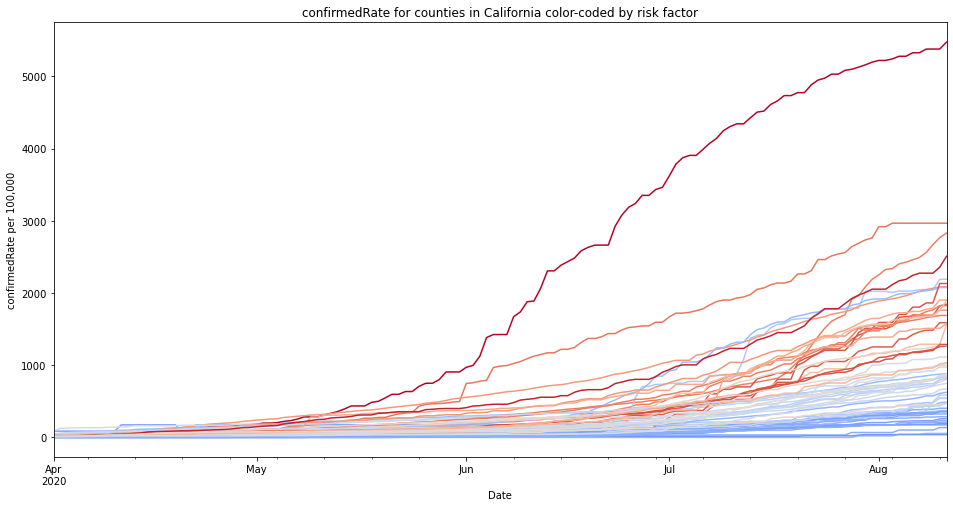

In [18]:
ax = df_date.plot(figsize=(16, 8), color=col_map, legend=False, title=f'{metric} for counties in {state} color-coded by risk factor');
ax.set_xlabel('Date');
ax.set_ylabel(f'{metric} per 100,000');

### Case counts by county color-coded by risk factor

In [19]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[1]/cols)

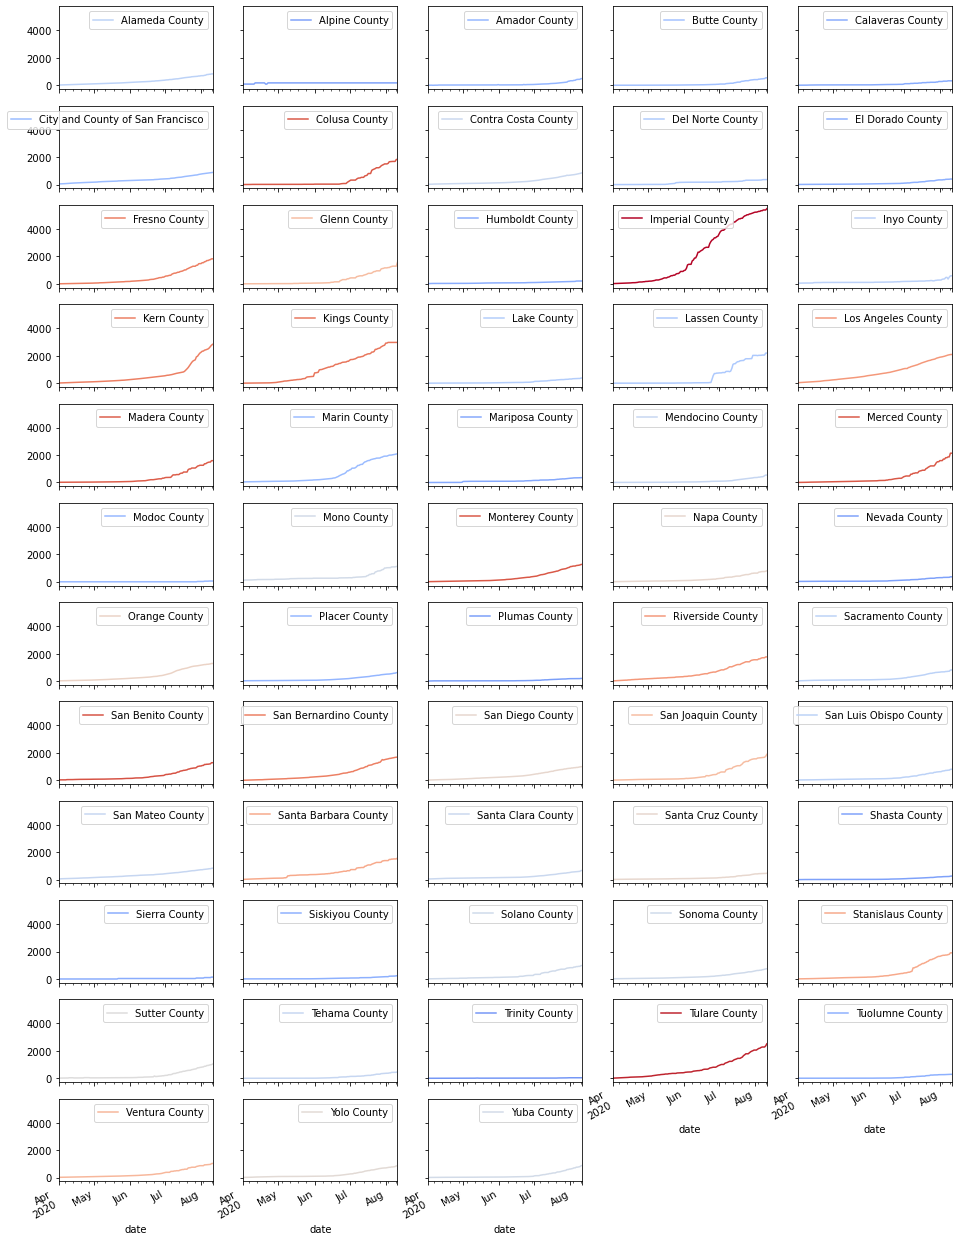

In [20]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 2*rows), color=col_map);

### Check for Correlations at a specific day

In [21]:
date = '2020-08-10'

In [22]:
query = """
// get all counties (admin2) in a state (admin1)
MATCH (a:Admin2)-[:IN]->(:Admin1{name: $admin1})

// get COVID-19 cases for all counties
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'}) 
WHERE c.date = date($date)

// get demographics for all counties
MATCH (a)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

RETURN a.name AS name,
       c.cummulativeConfirmed*100000.0/d.totalPopulation AS confirmedRate, 
       c.cummulativeDeaths*100000.0/d.totalPopulation AS deathRate
ORDER BY c.date ASC, a.name
"""
day_rate = graph.run(query, admin1=state, date=date).to_data_frame()

In [23]:
day_rate.head()

,name,confirmedRate,deathRate
0,Alameda County,829.287583,12.715216
1,Alpine County,174.520070,0.000000
2,Amador County,481.112374,5.286949
3,Butte County,545.194319,3.523065
4,Calaveras County,324.969603,2.210678


In [24]:
risk_corr = day_rate.merge(risk_features, left_on='name', right_on='name')

In [25]:
corr = risk_corr.corr()

In [26]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,confirmedRate,deathRate,hispanicOrLatinoPct,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,noInternetPct,highOccupanyHousingPct,averageHouseholdSize
confirmedRate,1.00,0.87,0.82,-0.00,0.05,0.20,-0.16,0.73,0.07,0.61,0.66
deathRate,0.87,1.00,0.69,-0.02,0.15,0.15,-0.11,0.55,0.06,0.53,0.59
hispanicOrLatinoPct,0.82,0.69,1.00,-0.10,-0.03,0.38,-0.27,0.90,0.04,0.83,0.81
minorityPct,-0.00,-0.02,-0.10,1.00,0.06,0.05,0.13,0.00,-0.04,-0.06,0.21
lowIncomePct,0.05,0.15,-0.03,0.06,1.00,0.20,0.50,0.20,0.80,-0.14,-0.19
noHealthInsurancePct,0.20,0.15,0.38,0.05,0.20,1.00,0.17,0.42,0.36,0.23,0.34
serviceOccupationPct,-0.16,-0.11,-0.27,0.13,0.50,0.17,1.00,-0.12,0.50,-0.39,-0.36
lowEducationPct,0.73,0.55,0.90,0.00,0.20,0.42,-0.12,1.00,0.31,0.75,0.70
noInternetPct,0.07,0.06,0.04,-0.04,0.80,0.36,0.50,0.31,1.00,-0.17,-0.21
highOccupanyHousingPct,0.61,0.53,0.83,-0.06,-0.14,0.23,-0.39,0.75,-0.17,1.00,0.72
